In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Simulating hexagonal data and running GD

In [23]:
# GENERATE HEXAGONAL SYMMETRY DATA

def gaussian_intensity(x, y, center_x, center_y, sigma=5):
    """
    Generate a Gaussian intensity signal at a point (x, y) with a center (center_x, center_y).
    
    Parameters:
    - x, y: Mesh grid coordinates
    - center_x, center_y: Coordinates of the Gaussian center
    - sigma: Standard deviation of the Gaussian (controls width of the peak)
    
    Returns:
    - Intensity values based on the Gaussian function
    """
    return np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

sigma=4.5959 # value picked to get the resolution of experiment, in this case 10.8deg
def plot_hexagonal_gaussians(rotation_angle, grid_size=128, hex_radius=50, sigma=sigma):

    FWHM = 2.35 * sigma
    # Create mesh grid for the intensity pattern
    x = np.linspace(-grid_size // 2, grid_size // 2, grid_size)
    y = np.linspace(-grid_size // 2, grid_size // 2, grid_size)
    X, Y = np.meshgrid(x, y)

    angles = np.linspace(0, 2 * np.pi, 7) + np.radians(rotation_angle)
    hexagon_x = hex_radius * np.cos(angles)
    hexagon_y = hex_radius * np.sin(angles)

    # Initialize the intensity grid
    intensity_grid = np.zeros((grid_size, grid_size))

    # Add Gaussian signals at each vertex
    for i in range(6):
        intensity_grid += gaussian_intensity(X, Y, hexagon_x[i], hexagon_y[i], sigma)

    # plt.imshow(intensity_grid, cmap='viridis', origin='lower')
    # plt.title(f'FWHM = {FWHM:.3f}')
    # # plt.colorbar()
    # plt.show()

    return FWHM, intensity_grid


In [24]:
sim_intensity_data = []
for i in np.arange(0, 360.5, .5):
    _, data = plot_hexagonal_gaussians(i)
    sim_intensity_data.append((data, i+30))

print(sim_intensity_data[1][1])

30.5


In [25]:
# SIMPLE GD

# Extract data_theta, doesn't matter what image is extracted since we're just getting theta
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
# DATA = np.load('/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/image_111001.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))
resolution = 10.8 #degrees
offset = torch.tensor(0., requires_grad=True)

# for the model
MAX_ITER_OFFSET = 101
LR = 1e-2

n_folds = 6
def filter_function(k, theta, n_folds=n_folds):
    filter = torch.exp(k * torch.log((torch.cos(n_folds / 2 * theta))**2))
    return filter

def k_val(fwhm):
    '''fwhm is your resolution given in degrees.

    This is derived based off the assumption that FWHM for the cosine 
    is approximately equal to a gaussian, which is a good assumption for this case
    Because FWHM for the cosine filter is approx equal to FWHM for a gaussian'''
    fwhm = np.deg2rad(fwhm)
    k = np.log(1/2) / (np.log(np.cos(3/2*fwhm)**2))
    return k

k = k_val(resolution)
print('k =', k)

def gradient_descent_optimize_offset(intensity, offset, k=k):
    intensity = torch.tensor(intensity)
    opt = torch.optim.Adam([offset], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta = filter_function(k, DATA_THETA+offset)
        loss = -(intensity * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
    return offset, evaluate_image_theta, loss

k = 8.553968178278982


In [26]:
# RUN GD
offset = torch.tensor(0., requires_grad=True)
true_offsets, GD_offsets, filters = [], [], []

for i in range(len(sim_intensity_data)):
   offset, filter, loss = gradient_descent_optimize_offset(sim_intensity_data[i][0], offset)
   GD_offsets.append(np.rad2deg(offset.item()))
   true_offsets.append(sim_intensity_data[i][1])
   filters.append(filter.detach())
   # plt.imshow(filter.detach())
   # plt.show()
   # print(np.rad2deg(offset.item()))
   # print(sim_intensity_data[i][1])




0.0023892979907343256


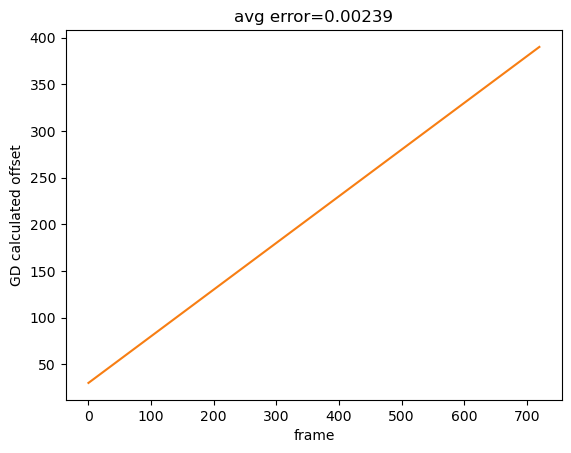

In [28]:

true_offsets_array = np.array(true_offsets)
GD_offsets_array = np.array(GD_offsets)
diff = true_offsets_array - GD_offsets_array
# plt.plot(diff)
error = np.average(diff)
print(error)
plt.errorbar(range(len(GD_offsets)), GD_offsets, yerr=error, fmt='-', alpha=.03)
plt.plot(GD_offsets)
plt.xlabel('frame')
plt.ylabel('GD calculated offset')
plt.title(f'avg error={error:.5f}')
plt.show()


## Error calcuated from "stationary" movie 121855.npz

(60, 128, 128)


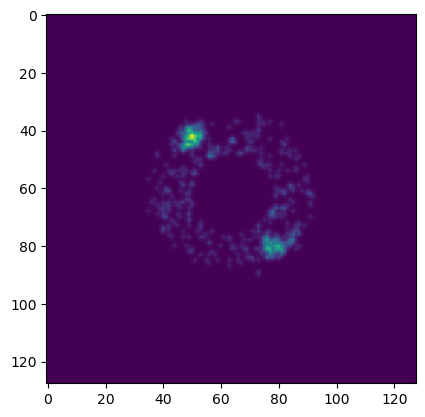

In [58]:
stationary_data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/122875.npz')['data']
print(stationary_data.shape)
plt.imshow(stationary_data[0])

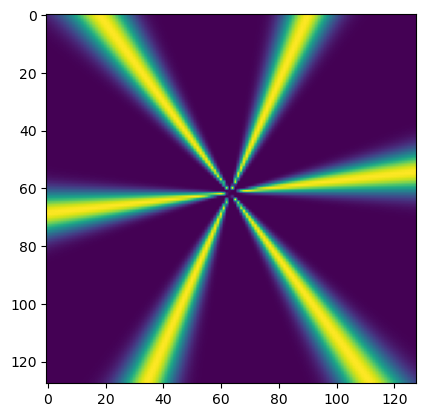

0.4118245840072632


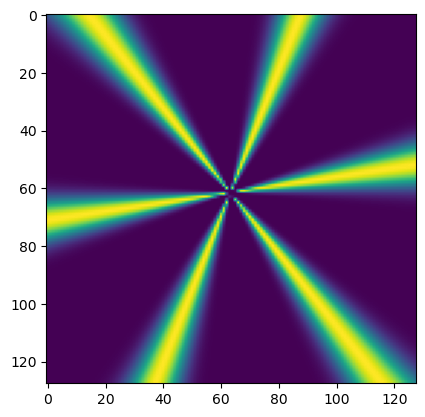

0.37541306018829346


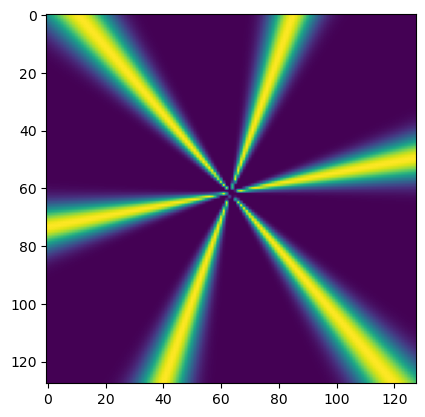

0.33875447511672974


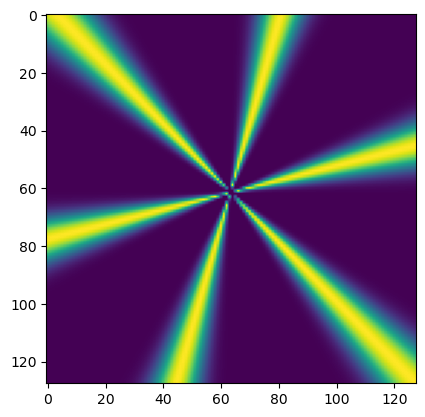

0.27528539299964905


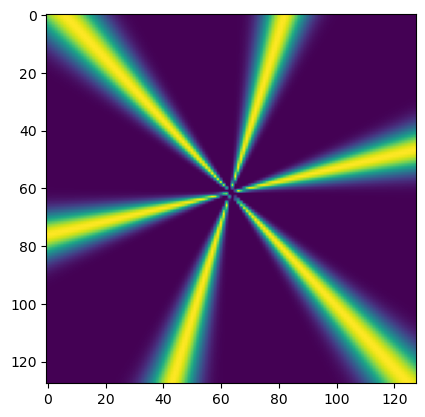

0.2965666353702545


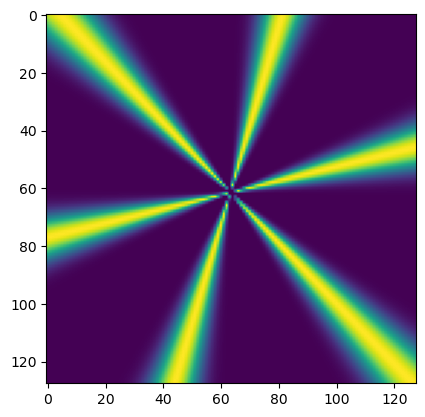

0.28393542766571045


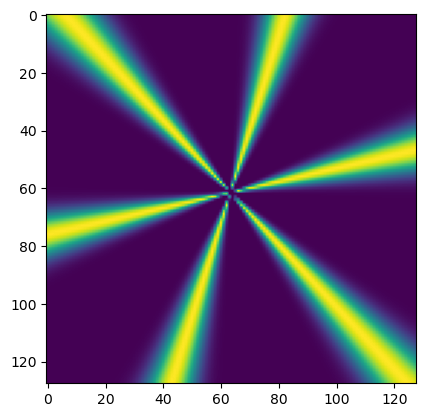

0.29888901114463806


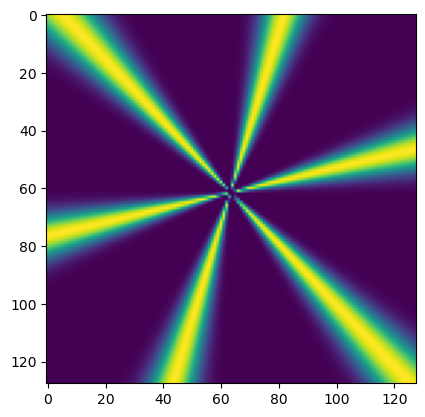

0.29174599051475525


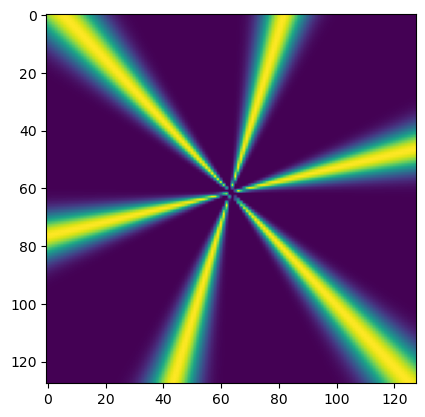

0.29259851574897766


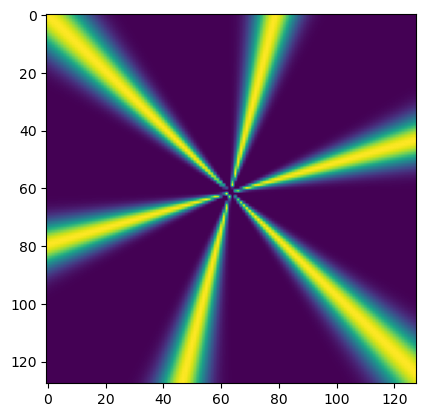

0.2476188987493515


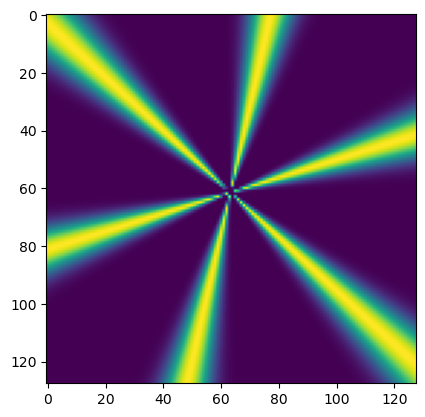

0.2226075381040573


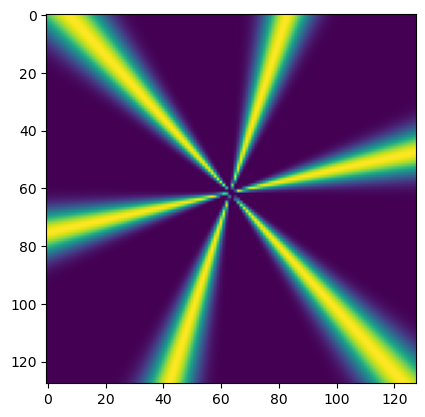

0.3093259334564209


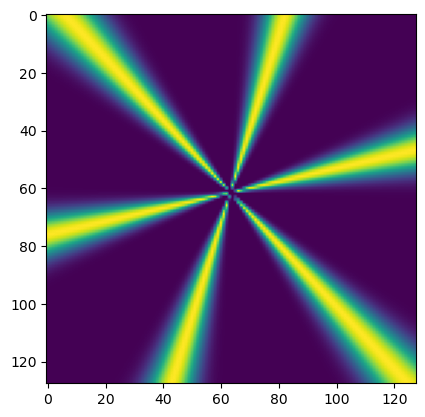

0.29814720153808594


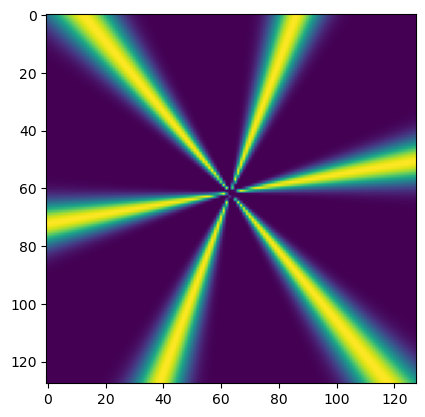

0.35595250129699707


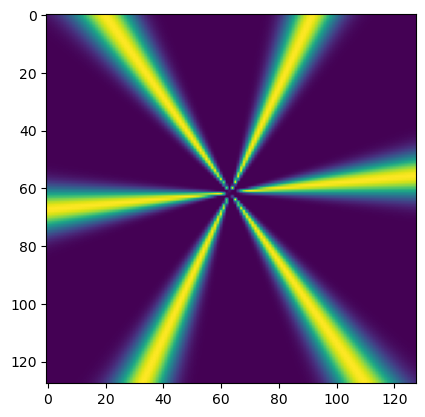

0.4321962594985962


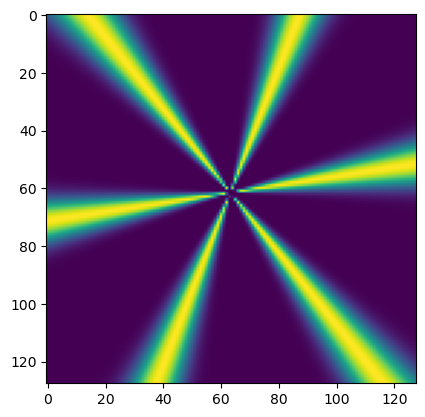

0.3710499405860901


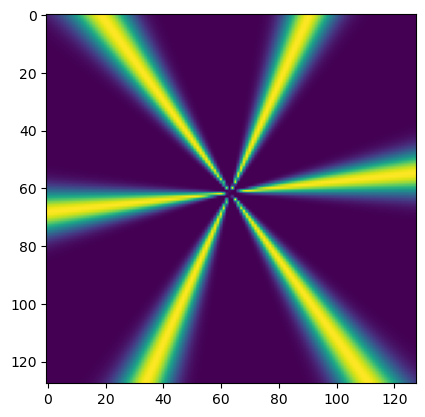

0.418279767036438


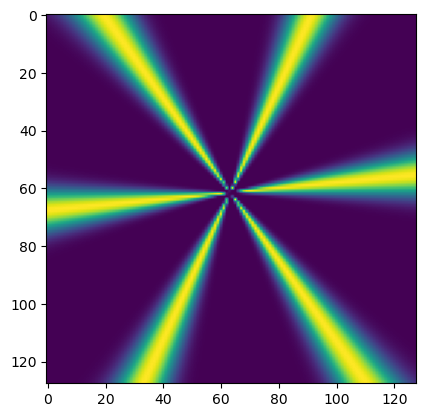

0.4280931353569031


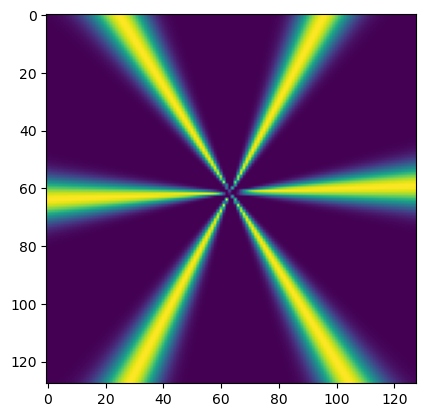

0.4868590533733368


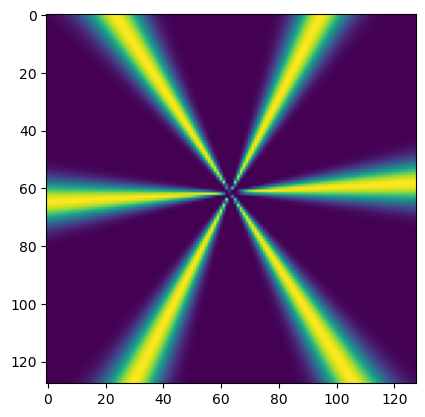

0.4722157418727875


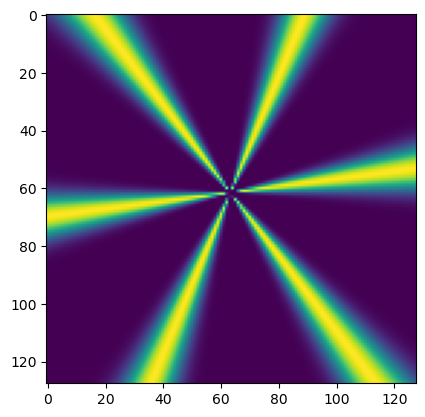

0.39457184076309204


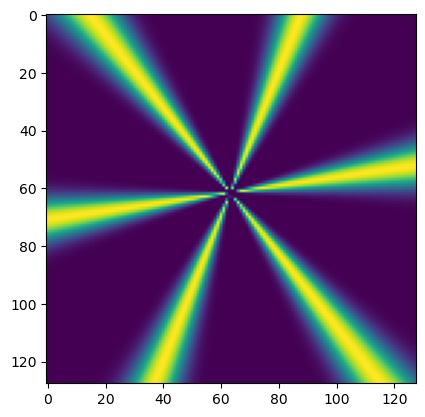

0.378476619720459


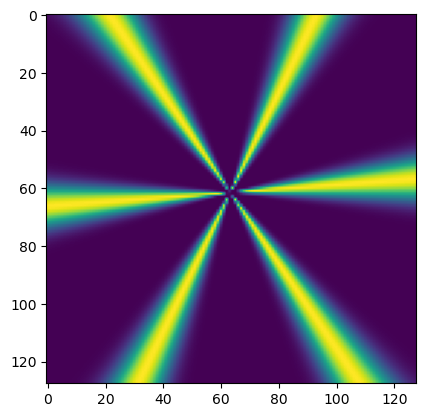

0.4502091407775879


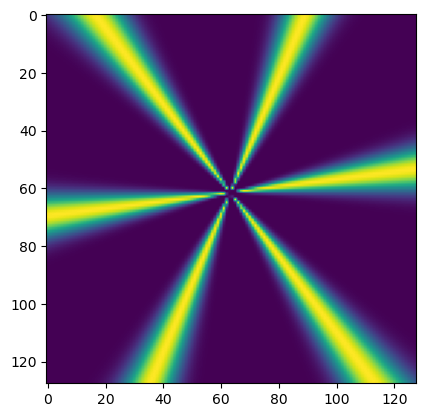

0.39783942699432373


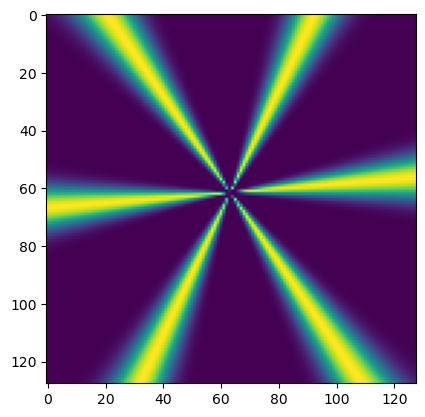

0.44188278913497925


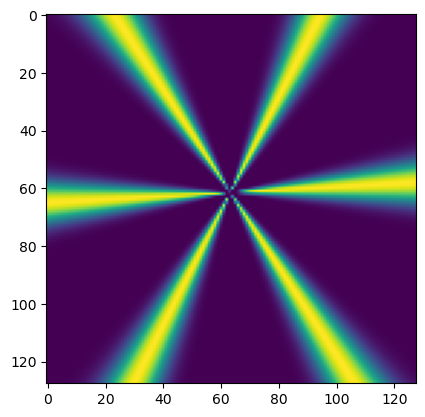

0.46933963894844055


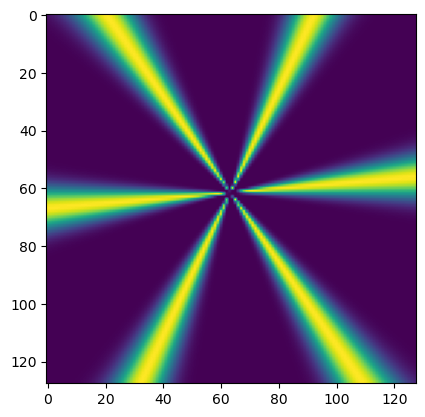

0.43934348225593567


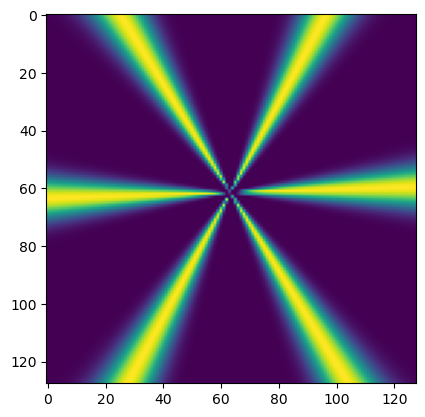

0.4929885268211365


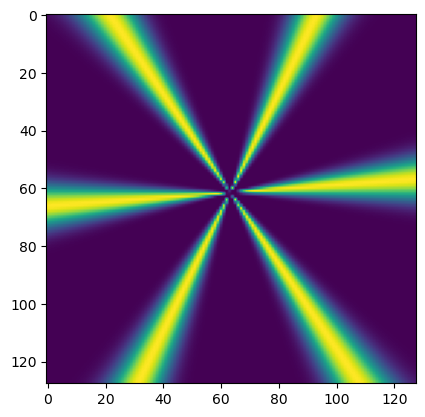

0.4510970115661621


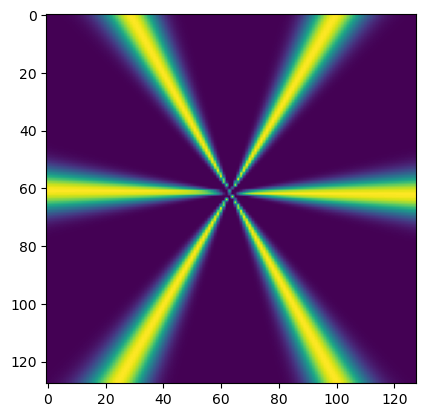

0.5350291132926941


In [94]:
offset = torch.tensor(0., requires_grad=True)
stationary_offsets = []
filters = []
for i in range(30):
    offset, filter, _ = gradient_descent_optimize_offset(cut_stack[i], offset)
    stationary_offsets.append(offset.item())
    filters.append(filter.detach())
    plt.imshow(filter.detach())
    plt.show()
    print(offset.item())

In [60]:
# filters_array = np.array(filters)
# filter_signal = [i for i in range(filters_array + stationary_data

In [99]:
# import imageio
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import zoom

# def gif_to_image_stack(gif_filename, target_size=(128, 128)):
#     """
#     Convert a GIF into a list of resized NumPy arrays for intensity data analysis.
    
#     Parameters:
#     - gif_filename: Path to the GIF file.
#     - target_size: Desired size for each frame (width, height).
    
#     Returns:
#     - A list of 2D NumPy arrays (grayscale intensity values) resized to target_size.
#     """
#     # Read the GIF file
#     gif = imageio.mimread(gif_filename)
    
#     # Convert each frame to a grayscale intensity array and resize
#     image_stack = []
#     for frame in gif:
#         # Convert to grayscale if necessary
#         if frame.ndim == 3:  # If the frame is RGB, convert to grayscale
#             frame = np.mean(frame, axis=2)
        
#         # Normalize the intensity values to be between 0 and 1
#         frame_normalized = frame / 255.0
        
#         # Resize to target size using zoom
#         zoom_factors = (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1])
#         resized_frame = zoom(frame_normalized, zoom_factors, order=1)
        
#         image_stack.append(resized_frame)
    
#     return image_stack

# # Example usage:
# image_stack = gif_to_image_stack('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/Movies/100mW_sweep_gifs/121550 56.8K -29mT.gif', target_size=(128, 128))

# # Check the shape of the extracted frames
# print(f"Extracted {len(image_stack)} frames with shape {image_stack[0].shape}")

# # Plot the first frame to verify the resizing
# plt.imshow(image_stack[0], cmap='gray')
# plt.title('First Frame of Resized GIF')
# plt.show()



In [ ]:
# image_stack = np.array(image_stack)
# cut_stack = image_stack
# for i in range(18):
#     cut_stack[:,i,:] = 0
# cut_stack.shape

(31, 128, 128)

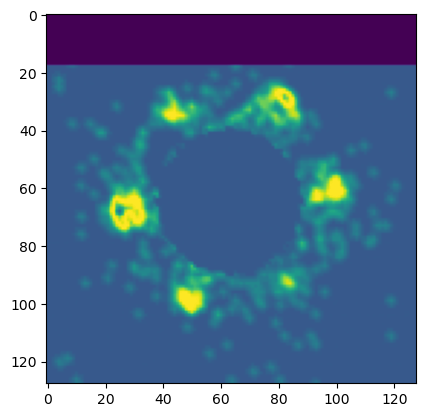

In [93]:
plt.imshow(cut_stack[0])

In [ ]:
import imageio
import numpy as np

def create_gif(images, output_filename='output.gif', fps=10):
    """
    Create a GIF from a list of images.
    
    Parameters:
    - images: List of NumPy arrays (grayscale or RGB).
    - output_filename: The filename for the output GIF.
    - fps: Frames per second (controls speed of the GIF).
    """
    # Ensure all images are in the correct format (uint8)
    processed_images = [(img * 255).numpy().astype(np.uint8) if img.max() <= 1 else img for img in images]

    # Write images to a GIF file
    imageio.mimsave(output_filename, processed_images, fps=fps)
    print(f"GIF saved as {output_filename}")

# Example usage:
# Assuming `image_list` is your list of NumPy arrays
# create_gif(filters, 'my_gif.gif', fps=10)


GIF saved as my_gif.gif


error= 10.846221556688693


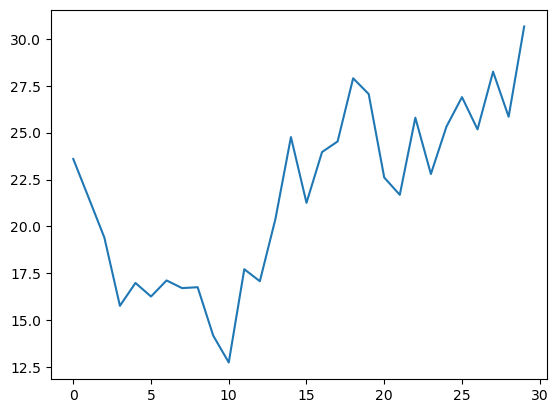

In [100]:
stationary_offsets_array = np.rad2deg(np.array(stationary_offsets))
plt.plot(stationary_offsets_array)
print('error=', np.average(stationary_offsets_array)/2)